In [1]:
import sys,os
# print(os.path.dirname("C:\Users\epena\OneDrive\Escritorio\qml\m_thesis_git"))
sys.path.append('C:\\Users\\epena\\OneDrive\\Escritorio\\qml\\m_thesis_git\\src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.utils import algorithm_globals

from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds

# Set a random seed
np.random.seed(42)

In [3]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

In [4]:
from qiskit.quantum_info import SparsePauliOp

# construct parametrized circuit
inputs = ParameterVector('input', length=3) # 1 extra for label
weights = ParameterVector('weight', length=9)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.u(inputs[0],inputs[1],inputs[2], 0)
qc1.u(weights[0],weights[1],weights[2], 0)
qc1.u(inputs[0],inputs[1],inputs[2], 0)
qc1.u(weights[3],weights[4],weights[5], 0)
qc1.u(inputs[0],inputs[1],inputs[2], 0)
qc1.u(weights[6],weights[7],weights[8], 0)

op1 = SparsePauliOp.from_list([('Z', 1.0)])
op2 = SparsePauliOp.from_list([('Z', -1.0)])

In [5]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.algorithms.gradients import ReverseEstimatorGradient as REG
from qiskit.primitives import Estimator

estimator = Estimator()
gradient = REG(estimator)
qnn1 = EstimatorQNN(circuit=qc1, observables=op1, input_params=inputs, weight_params=weights, estimator=estimator, gradient=gradient)
qnn2 = EstimatorQNN(circuit=qc1, observables=op2, input_params=inputs, weight_params=weights, estimator=estimator, gradient=gradient)

In [6]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [7]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)

fit_result = optimizer.minimize(
    fun=function.objective,
    x0=algorithm_globals.random.random(qnn1.num_weights),
    jac=function.gradient)

C:\Users\epena\anaconda3\lib\site-packages\qiskit\algorithms\gradients\base_estimator_gradient.py:259: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


weights:  [0.64082826 0.39235737 0.142415   0.18544669 0.0606845  0.11354871
 0.75820469 0.71735656 0.61096885]
loss:  1.346922469482899
weights:  [-0.01009182  0.35234098 -0.20494623 -0.38042971  0.07920794  0.1037663
  0.47269927  0.71735656  0.83872674]
loss:  0.9945545450594099
weights:  [ 0.07563182  0.28695587 -0.3020428  -0.40469362 -0.09341091  0.04173508
  0.27248562  0.71735656  0.76518996]
loss:  0.9293478332354971
weights:  [ 0.19645652  0.29421589 -0.32212365 -0.43237221 -0.20930694  0.08293572
  0.1055189   0.71735656  0.69280261]
loss:  0.9080138471138843
weights:  [ 0.35590289  0.32680058 -0.29147398 -0.56130436 -0.27881705  0.16822777
 -0.04808656  0.71735656  0.63216436]
loss:  0.8932495452953221
weights:  [ 0.73186482  0.32775474 -0.18593899 -0.87458456 -0.34782827  0.24966149
 -0.18696091  0.71735656  0.51773078]
loss:  0.8760739097898879
weights:  [ 1.1970595   0.21485909 -0.00933242 -1.30189171 -0.36751748  0.21604981
 -0.22734672  0.71735656  0.36282443]
loss:  0

weights:  [ 2.04214684 -0.72699215  0.52397538 -0.73165772  0.49644923  0.83710239
 -1.53949475  0.71735656 -0.53498428]
loss:  0.5257874383601192
weights:  [ 2.04214684 -0.72699215  0.52397538 -0.73165772  0.49644923  0.83710239
 -1.53949475  0.71735656 -0.53498428]
loss:  0.5257874383601192


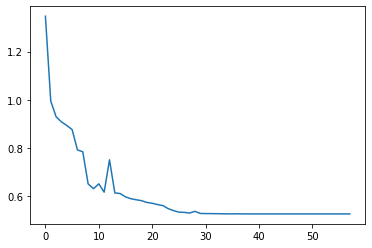

In [8]:
plt.plot(losses)

In [8]:
ws = [-0.91709316,  1.57980935, -1.61740473,  1.1182353,  -1.56539397,  1.52962569,
 -1.52987669,  0.00201624,  1.47818211]

new_ws = [2.04214684, -0.72699215,  0.52397538, -0.73165772,  0.49644923,  0.83710239,
 -1.53949475,  0.71735656, -0.53498428]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, new_ws)


Accuracy:  0.885
tp:  82 tn:  95  fp:  17  fn:  6


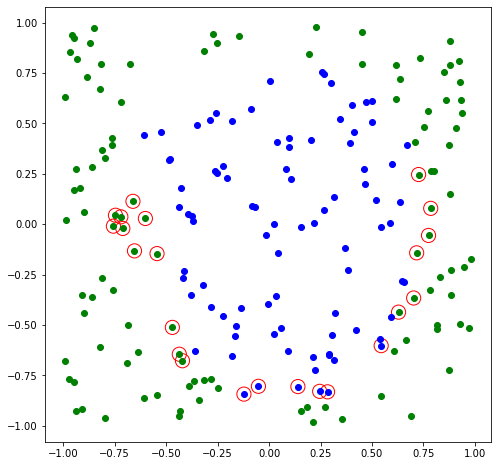

In [9]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [10]:
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

Accuracy:  0.932
tp:  935 tn:  929  fp:  68  fn:  68


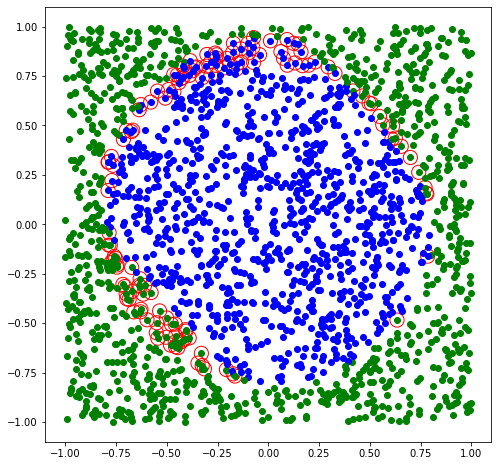

In [11]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()